In [ ]:
import bitarray

def tobitarray(s:str)->bitarray:
    ba = bitarray.bitarray()
    ba.frombytes(s.encode('utf-8'))
    return ba

def tostr(b:bitarray)->str:
    return bitarray.bitarray(b.tolist()).tobytes().decode('utf-8')

def padzero(b:bitarray,N:int)->bitarray:
    print(b.length())
    
#print(tobitarray('Hi').length())

[1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1
 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0]


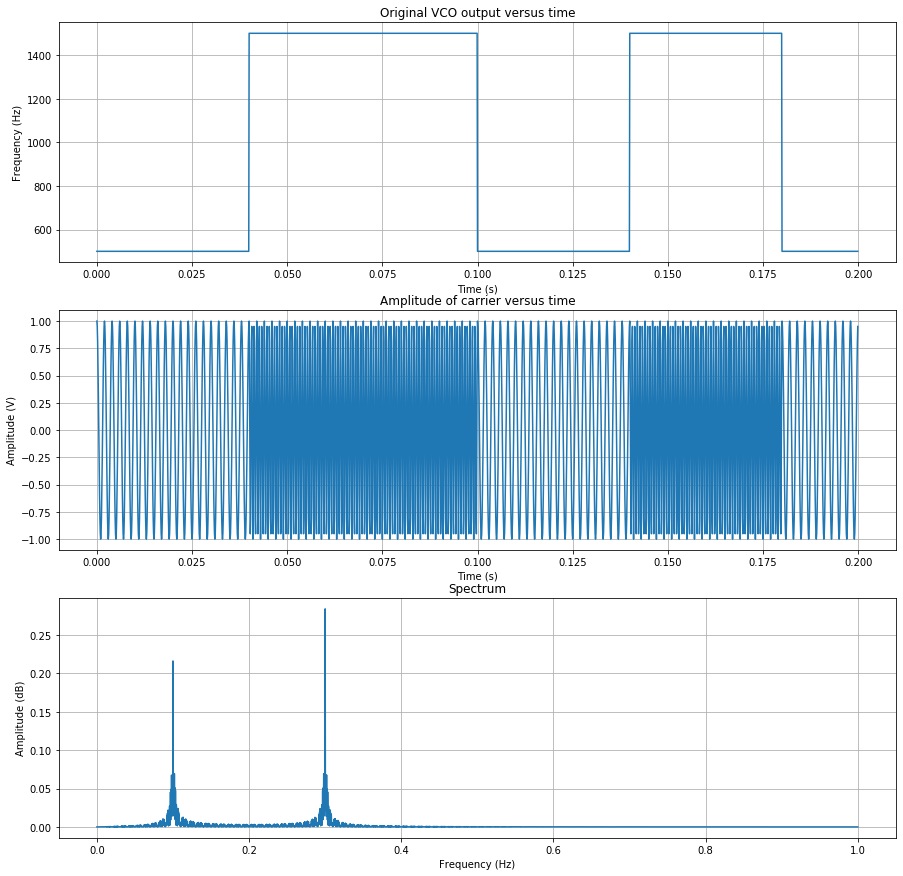

SNR = 13.919012dB


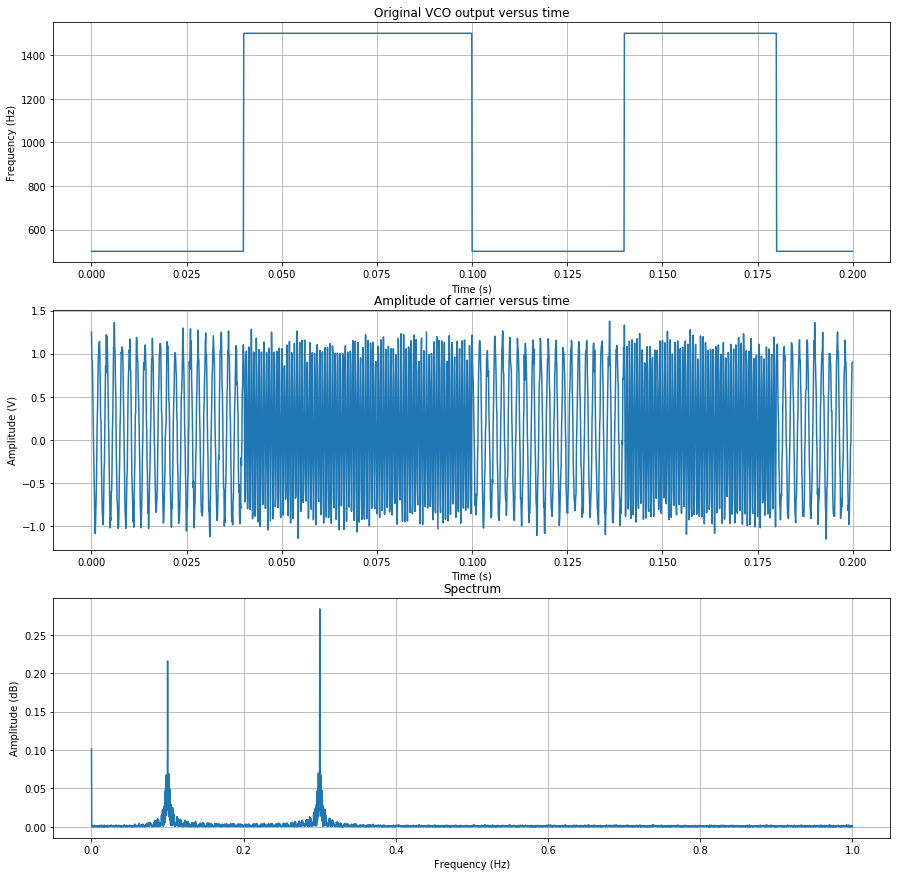

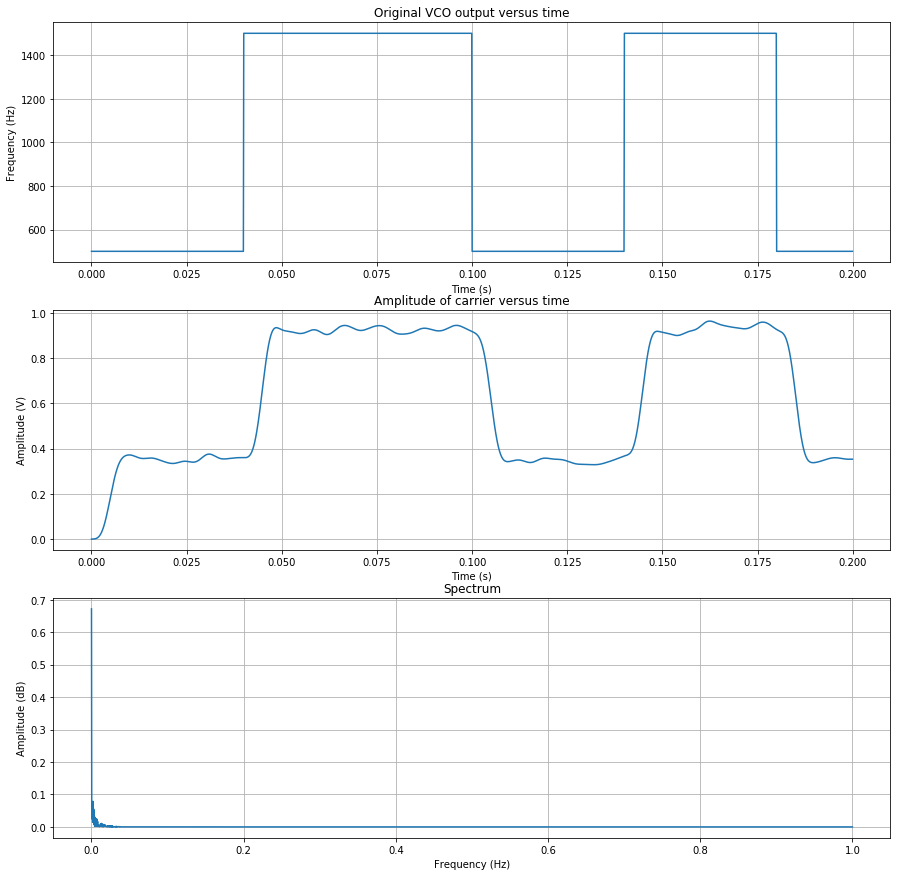

bit errors = 0
bit error percent = 0.00%
[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


In [2]:
import numpy as np
import pylab as pl
import scipy.signal.signaltools as sigtool
import scipy.signal as signal
from numpy.random import sample
import matplotlib.pyplot as plt

"""
Input DATA
"""
#data_in = tobitarray("Hello X \xC6 A-12 Musk") 

#the following variables setup the system
Fc = 1000       #simulate a carrier frequency of 1kHz
Fbit = 50       #simulated bitrate of data
Fdev = 500      #frequency deviation, make higher than bitrate
N = 64          #how many bits to send
#N = data_in.length()
A = 1           #transmitted signal amplitude
Fs = 10000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
A_n = 0.1       #noise peak amplitude
N_prntbits = 10 #number of bits to print in plots

def plot_data(y):
    #view the data in time and frequency domain
    #calculate the frequency domain for viewing purposes
    np.seterr(divide = 'ignore') 
    pl.figure(figsize=(15,15))
    N_FFT = float(len(y))
    f = np.arange(0,Fs/2,Fs/N_FFT)
    w = np.hanning(len(y))
    y_f = np.fft.fft(np.multiply(y,w))
    y_f = 10*np.log10(np.abs((y_f[0:int(N_FFT//2)])//(N_FFT)))
    pl.subplot(3,1,1)
    pl.plot(t[0:int(Fs*N_prntbits//Fbit)],m[0:int(Fs*N_prntbits//Fbit)])
    pl.xlabel('Time (s)')
    pl.ylabel('Frequency (Hz)')
    pl.title('Original VCO output versus time')
    pl.grid(True)
    pl.subplot(3,1,2)
    pl.plot(t[0:int(Fs*N_prntbits//Fbit)],y[0:int(Fs*N_prntbits//Fbit)])
    pl.xlabel('Time (s)')
    pl.ylabel('Amplitude (V)')
    pl.title('Amplitude of carrier versus time')
    pl.grid(True)
    pl.subplot(3,1,3)
    plt.magnitude_spectrum(y)
    pl.xlabel('Frequency (Hz)')
    pl.ylabel('Amplitude (dB)')
    pl.title('Spectrum')
    pl.grid(True)
    #l.tight_layout()
    pl.show()
    
"""
Data in
"""
#generate some random data for testing
data_in = np.random.randint(0,2,N)
print(data_in)


t = np.arange(0,float(N)/float(Fbit),1/float(Fs), dtype=np.float)
#extend the data_in to account for the bitrate and convert 0/1 to frequency
m = np.zeros(0).astype(float)
for bit in data_in:
    if bit == 0:
        m=np.hstack((m,np.multiply(np.ones(Fs//Fbit),Fc+Fdev)))
    else:
        m=np.hstack((m,np.multiply(np.ones(Fs//Fbit),Fc-Fdev)))
#calculate the output of the VCO
y=np.zeros(0)
y=A * np.cos(2*np.pi*np.multiply(m,t))
plot_data(y)

"""
Noisy Channel
"""
#create some noise
noise = (np.random.randn(len(y))+1)*A_n
snr = 10*np.log10(np.mean(np.square(y)) / np.mean(np.square(noise)))
print ("SNR = %fdB" % snr)
y=np.add(y,noise)
#view the data after adding noise
plot_data(y)

"""
Differentiator
"""
y_diff = np.diff(y,1)

"""
Envelope detector + low-pass filter
"""
#create an envelope detector and then low-pass filter
y_env = np.abs(sigtool.hilbert(y_diff))
h=signal.firwin( numtaps=100, cutoff=Fbit*2, nyq=Fs/2)
y_filtered=signal.lfilter( h, 1.0, y_env)

plot_data(y_filtered)

"""
slicer
"""
#calculate the mean of the signal
mean = np.mean(y_filtered)
#if the mean of the bit period is higher than the mean, the data is a 0
rx_data = []
sampled_signal = y_filtered[int(Fs/Fbit/2):len(y_filtered):int(Fs/Fbit)]
for bit in sampled_signal:
    if bit > mean:
        rx_data.append(0)
    else:
        rx_data.append(1)

bit_error=0
for i in range(0,len(data_in)):
    if rx_data[i] != data_in[i]:
        bit_error+=1
print ("bit errors = %d" % bit_error)
print ("bit error percent = %4.2f%%" % (float(bit_error)/float(N)*100))
print(rx_data)
#print(tostr(bitarray.bitarray(rx_data)))

In [14]:
import numpy as np
import pylab as pl
import scipy.signal.signaltools as sigtool
import scipy.signal as signal
from numpy.random import sample
import matplotlib.pyplot as plt
import bitarray


def modulation(data_in,debug=False):
    Fc = 1000       #simulate a carrier frequency of 1kHz
    Fbit = 50       #simulated bitrate of data
    Fdev = 500      #frequency deviation, make higher than bitrate
    #N = 64          #how many bits to send
    N = len(data_in)
    A = 1           #transmitted signal amplitude
    Fs = 10000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
    A_n = 0.1       #noise peak amplitude
    N_prntbits = 10 #number of bits to print in plots

    if debug:
        print(data_in)

    t = np.arange(0,float(N)/float(Fbit),1/float(Fs), dtype=np.float)
    
    #extend the data_in to account for the bitrate and convert 0/1 to frequency
    m = np.zeros(0).astype(float)
    for bit in data_in:
        if bit == 0:
            m=np.hstack((m,np.multiply(np.ones(Fs//Fbit),Fc+Fdev)))
        else:
            m=np.hstack((m,np.multiply(np.ones(Fs//Fbit),Fc-Fdev)))
    
    #calculate the output of the VCO
    y=np.zeros(0)
    y=A * np.cos(2*np.pi*np.multiply(m,t))
    if debug:
        plot_data(y)
    
    return y
        
def addnoise(y,debug=False):
    Fc = 1000       #simulate a carrier frequency of 1kHz
    Fbit = 50       #simulated bitrate of data
    Fdev = 500      #frequency deviation, make higher than bitrate
    #N = 64          #how many bits to send
    N = len(y)
    A = 1           #transmitted signal amplitude
    Fs = 10000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
    A_n = 0.1       #noise peak amplitude
    N_prntbits = 10 #number of bits to print in plots

    #create some noise
    noise = (np.random.randn(len(y))+1)*A_n
    snr = 10*np.log10(np.mean(np.square(y)) / np.mean(np.square(noise)))
    print ("SNR = %fdB" % snr)
    y=np.add(y,noise)
    #view the data after adding noise
    if debug:
        plot_data(y)
    return y

def demodulation(y,debug=False):
    Fc = 1000       #simulate a carrier frequency of 1kHz
    Fbit = 50       #simulated bitrate of data
    Fdev = 500      #frequency deviation, make higher than bitrate
    #N = 64          #how many bits to send
    N = len(y)
    A = 1           #transmitted signal amplitude
    Fs = 10000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
    A_n = 0.1       #noise peak amplitude
    N_prntbits = 10 #number of bits to print in plots

    y_diff = np.diff(y,1)

    #Envelope detector + low-pass filter
    y_env = np.abs(sigtool.hilbert(y_diff))
    h=signal.firwin( numtaps=100, cutoff=Fbit*2, nyq=Fs/2)
    y_filtered=signal.lfilter( h, 1.0, y_env)

    if debug:
        plot_data(y_filtered)

    #slicer
    #calculate the mean of the signal
    mean = np.mean(y_filtered)
    #if the mean of the bit period is higher than the mean, the data is a 0
    rx_data = []
    sampled_signal = y_filtered[int(Fs/Fbit/2):len(y_filtered):int(Fs/Fbit)]
    for bit in sampled_signal:
        if bit > mean:
            rx_data.append(0)
        else:
            rx_data.append(1)
    return rx_data

            
#bit_error=0
#for i in range(0,len(data_in)):
#    if rx_data[i] != data_in[i]:
#        bit_error+=1
#print ("bit errors = %d" % bit_error)
#print ("bit error percent = %4.2f%%" % (float(bit_error)/float(N)*100))
  


In [10]:
import pyaudio
import wave

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 11025  # Record at 44100 samples per second
seconds = 2
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')
# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()


Recording
Finished recording


In [21]:
data = b''.join(frames)
print(len(data))
ba = bitarray.bitarray()
ba.frombytes(data)

43008


In [ ]:
modulated_data = modulation(ba)

noisy_data = addnoise(modulated_data)

demodulated_data = demodulation(noisy_data)


In [18]:
len(modulated_data)

3276800